In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import heapq
from sklearn.datasets import make_blobs
import math
import copy

In [2]:
# points = [(1,9),(2,8),(1.5,7),(1,6),(2,6),(4,3),(5,3),(4,2),(5,5),(6,1)]
X, Y = make_blobs(n_samples=52, centers=5, random_state=42, cluster_std=[0.5, 0.7, 0.9, 1.2, 1.5])
points = [(x,y) for x,y in X]

In [3]:
class KDNode:
    def __init__(self, point, axis, left=None, right=None):
        self.point = point
        self.axis = axis
        self.left = left
        self.right = right

class KDTree:
    def __init__(self):
        self.root = None

    def build(self, points, depth=0):
        if not points:
            return None
        
        k = len(points[0])  # Dimensionality of the data
        axis = depth % k

        # Sort points by the current axis and choose the median as the pivot
        points.sort(key=lambda x: x[axis])
        median = len(points) // 2

        return KDNode(
            point=points[median],
            axis=axis,
            left=self.build(points[:median], depth + 1),
            right=self.build(points[median + 1:], depth + 1)
        )

    def insert(self, point):
        def _insert_rec(node, point, depth=0):
            if node is None:
                k = len(point)
                return KDNode(point, depth % k)
            
            if point[node.axis] < node.point[node.axis]:
                node.left = _insert_rec(node.left, point, depth + 1)
            else:
                node.right = _insert_rec(node.right, point, depth + 1)
            
            return node

        self.root = _insert_rec(self.root, point)


In [4]:
tree = KDTree()

tree.root = tree.build(points)


In [5]:
def ith_nearest_neighbor(tree, query_point, i):
    """Find the ith nearest neighbor of the given point using a set to track visited nodes."""
    if tree.root is None:
        return None

    # Priority queue to maintain i nearest neighbors
    neighbors = []
    
    # Set to track visited nodes
    visited = set()

    def _search(node):
        if node is None or node in visited:
            return

        visited.add(node)

        # Calculate distance from the current node to the query point
        distance = sum([(a - b) ** 2 for a, b in zip(node.point, query_point)]) ** 0.5

        # If we have less than i neighbors, just add the current node
        if len(neighbors) < i:
            heapq.heappush(neighbors, (-distance, node.point))
        else:
            # If the current node is closer than the farthest neighbor, update the queue
            if distance < -neighbors[0][0]:
                heapq.heappop(neighbors)
                heapq.heappush(neighbors, (-distance, node.point))

        axis = node.axis
        next_branch = None
        opposite_branch = None

        if query_point[axis] < node.point[axis]:
            next_branch = node.left
            opposite_branch = node.right
        else:
            next_branch = node.right
            opposite_branch = node.left

        # Recursively search the half of the tree that contains the test point
        _search(next_branch)

        # If difference between splitting coordinate and test point's coordinate is
        # less than the distance from test point to the farthest neighbor, search the other half
        if (len(neighbors) < i or
                abs(query_point[axis] - node.point[axis]) < -neighbors[0][0]):
            _search(opposite_branch)

    _search(tree.root)

    # Return the i-th nearest neighbor
    return neighbors[0][1]

# Test the modified function
query_point = (1, 9)
ith_point_with_set = ith_nearest_neighbor(tree, query_point, 3)
ith_point_with_set


(-2.4754335207087883, 8.301912035091593)

In [6]:
k = 2
Nb = {pt:0 for pt in points}
# count num of 0s in Nb
NN = {pt:set() for pt in points}
RNN = {pt:set() for pt in points}
NaN = {pt:set() for pt in points}

while True:
    zeros_in_Nb = sum(1 for value in Nb.values() if value == 0)
    for pointi in points:
        pointj = ith_nearest_neighbor(tree, pointi, k)
        
        if pointj not in NN[pointi]:
            NN[pointi].add(pointj)
            RNN[pointj].add(pointi)
            Nb[pointj] += 1
        # print(Nb , NN , RNN) 
    new_zeros_in_Nb = sum(1 for value in Nb.values() if value == 0)
    if new_zeros_in_Nb == zeros_in_Nb:
        break
    k += 1
NaN = {pt : NNi.intersection(RNNi) for pt , NNi, RNNi in zip(points , NN.values(), RNN.values())}
# print(NN )
# print(RNN)
# print(NaN)

In [7]:
def distance(point1, point2):
    return sum([(a - b) ** 2 for a, b in zip(point1, point2)]) ** 0.5

In [8]:
def matplot(neibours_set , name_of_graph = "graph"):
    x_cords = [x for x,y in points]
    y_cords = [y for x,y in points]
    weight = 0
    visited = set()
    plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)
    

    # Add edges based on the connections
    for pt in neibours_set.keys():
        for pt2 in neibours_set[pt]:
            if (pt,pt2) in visited:
                continue
            weight += distance(pt, pt2)
            visited.add((pt,pt2))
            visited.add((pt2,pt))
            plt.plot( (pt[0], pt2[0]) , (pt[1] , pt2[1]),  color='red', linestyle='--', linewidth=0.8)
    plt.title(f"{name_of_graph} no of edges = {len(visited)//2} , weight = {round(weight,2)}")

In [9]:
# matplot(NaN ,"NaN")


In [10]:
# matplot(NN , "NN")

In [11]:
Complete = {pt : set(points) - set([pt]) for pt in points}
# matplot(Complete, "Complete")

In [12]:
def mst(graph , name):
    edges = []
    for src, neighbors in graph.items():
        for dest in neighbors:
            if (src, dest) not in edges and (dest, src) not in edges:
                edges.append((src, dest, distance(src, dest)))

    # Sort edges by weight
    edges.sort(key=lambda x: x[2])

    # Helper function to find set of an item (with path compression)
    def find(item, parent):
        if parent[item] == item:
            return item
        parent[item] = find(parent[item], parent)  # Path compression
        return parent[item]

    # Helper function to union two sets
    def union(set1, set2, parent, rank):
        root1 = find(set1, parent)
        root2 = find(set2, parent)

        if root1 != root2:
            if rank[root1] > rank[root2]:
                parent[root2] = root1
            else:
                parent[root1] = root2
                if rank[root1] == rank[root2]:
                    rank[root2] += 1

    # Kruskal's algorithm
    def kruskal(edges):
        mst_dict = {pt : set() for pt in points}  # The MST in the desired format
        parent = {v: v for v, _, _ in edges}
        rank = {v: 0 for v, _, _ in edges}

        for edge in edges:
            src, dest, weight = edge
            if find(src, parent) != find(dest, parent):
                if src not in mst_dict:
                    mst_dict[src] = set()
                mst_dict[src].add(dest)

                union(src, dest, parent, rank)

        return mst_dict

    matplot(kruskal(edges) , name + " MST")
    return kruskal(edges)

    # Get the Minimum Spanning Tree
    
    

In [13]:
print (NN)

{(-11.982021881543703, 8.309805920748971): {(-8.881319003567953, 9.20109530247551), (-9.474040001156457, 7.93944383523473), (-8.721834697418362, 8.48589690413817), (-8.733871274750205, 6.964714094939662), (-9.101934022041025, 7.752058001312799), (-9.808520080107835, 6.721414463197259)}, (-9.808520080107835, 6.721414463197259): {(-9.474040001156457, 7.93944383523473), (-8.721834697418362, 8.48589690413817), (-8.733871274750205, 6.964714094939662), (-9.101934022041025, 7.752058001312799), (-7.7398452153935215, 7.718024247090325), (-8.728214824793408, 4.938440217977632)}, (-9.474040001156457, 7.93944383523473): {(-8.881319003567953, 9.20109530247551), (-8.721834697418362, 8.48589690413817), (-8.733871274750205, 6.964714094939662), (-9.101934022041025, 7.752058001312799), (-7.7398452153935215, 7.718024247090325), (-9.808520080107835, 6.721414463197259)}, (-9.101934022041025, 7.752058001312799): {(-8.881319003567953, 9.20109530247551), (-9.474040001156457, 7.93944383523473), (-8.72183469741

/tmp/ipykernel_30901/3317933049.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)


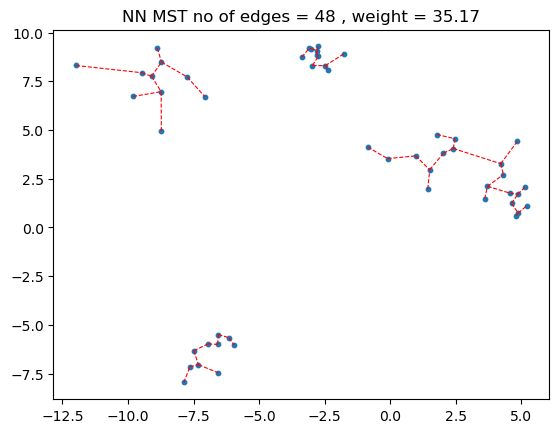

In [14]:
NN_mst = mst(NN , "NN")

/tmp/ipykernel_30901/3317933049.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)


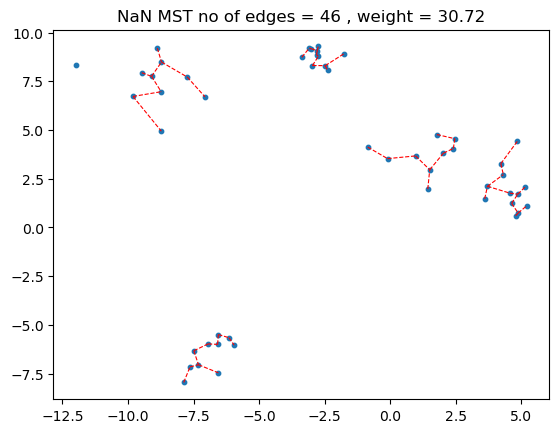

In [15]:
NaN_mst = mst(NaN , "NaN")

52 52 52


/tmp/ipykernel_30901/3317933049.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)


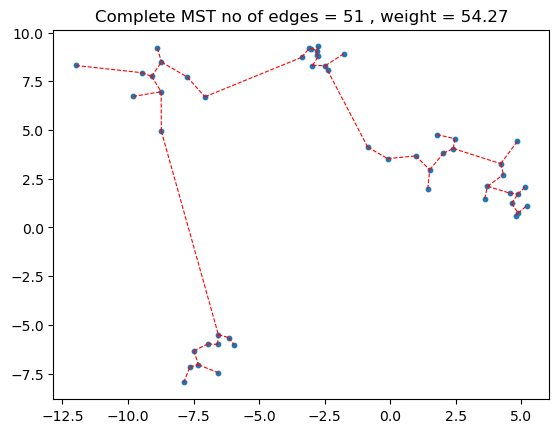

In [16]:
complete_mst = mst(Complete , "Complete")
print(len(complete_mst) , len(NN_mst) , len(NaN_mst))

In [17]:
print(NN_mst)

{(-11.982021881543703, 8.309805920748971): {(-9.474040001156457, 7.93944383523473)}, (-9.808520080107835, 6.721414463197259): {(-8.733871274750205, 6.964714094939662)}, (-9.474040001156457, 7.93944383523473): {(-9.101934022041025, 7.752058001312799)}, (-9.101934022041025, 7.752058001312799): {(-8.733871274750205, 6.964714094939662), (-8.721834697418362, 8.48589690413817)}, (-8.881319003567953, 9.20109530247551): {(-8.721834697418362, 8.48589690413817)}, (-8.733871274750205, 6.964714094939662): set(), (-8.728214824793408, 4.938440217977632): {(-8.733871274750205, 6.964714094939662)}, (-8.721834697418362, 8.48589690413817): {(-7.7398452153935215, 7.718024247090325)}, (-7.875328667756696, -7.95669555494855): {(-7.634922962051645, -7.15840073154204)}, (-7.7398452153935215, 7.718024247090325): {(-7.064854902946191, 6.7015986535703265)}, (-7.634922962051645, -7.15840073154204): {(-7.310884005212031, -7.047202672273382)}, (-7.488856991426633, -6.329600933319165): {(-7.310884005212031, -7.0472

In [18]:
def find_clusters(edge_dict):
    
    point_id = {pt : i for i, pt in enumerate(edge_dict.keys())}
    rpoint_id = {i : pt for i, pt in enumerate(edge_dict.keys())}
    root_id = {pt : i for i , pt in enumerate(edge_dict.keys())}
    childrens = {i : set([pt]) for i , pt in enumerate(edge_dict.keys())}
    no_of_clusters = len(edge_dict)
    
    for pt in edge_dict.keys():
        tmp_root_list = [[root_id[pt] , pt]]
        tmp_root_list += [[root_id[tpt] , tpt] for tpt in edge_dict[pt]]
        tmp_root_id = min(tmp_root_list)[0]
        
        for tid , tpt in tmp_root_list:
            if tid == tmp_root_id:
                continue
            for child in childrens[tid]:
                
                root_id[child] = tmp_root_id
                childrens[tmp_root_id].add(child)
                childrens[tid] = set()
                
            root_id[tpt] = tmp_root_id
            childrens[tmp_root_id].add(tpt)
            childrens[tid] = set()
    # print(childrens)
    cset = [[key , val ] for key , val in childrens.items() if len(val) > 0]
    # print(cset)
    return cset
    

In [19]:
NN_clusters = find_clusters(NN_mst)

In [20]:
print(NN_clusters)

[[0, {(-8.881319003567953, 9.20109530247551), (-11.982021881543703, 8.309805920748971), (-9.474040001156457, 7.93944383523473), (-8.721834697418362, 8.48589690413817), (-8.728214824793408, 4.938440217977632), (-8.733871274750205, 6.964714094939662), (-9.101934022041025, 7.752058001312799), (-7.064854902946191, 6.7015986535703265), (-7.7398452153935215, 7.718024247090325), (-9.808520080107835, 6.721414463197259)}], [8, {(-6.1483539509964915, -5.6594935675622065), (-5.951727620904914, -6.041957486071368), (-6.581490102888062, -6.002118978865823), (-7.488856991426633, -6.329600933319165), (-7.634922962051645, -7.15840073154204), (-7.875328667756696, -7.95669555494855), (-6.554371146193698, -5.495876683456574), (-6.5541547686084, -7.460717372420558), (-7.310884005212031, -7.047202672273382), (-6.944436300573571, -5.976929985173125)}], [20, {(-2.8095169680121526, 8.868439253301684), (-2.7813889853153415, 9.069747423053254), (-2.7409064694589813, 8.781421251413192), (-3.0846944117639015, 9.2

In [21]:
def find_centroid(point_list):
    x , y  = 0 , 0
    for px , py in point_list:
        x , y = x + px , y + py
    return (x/len(point_list) , y/len(point_list))
    
    

In [22]:
# def 

In [23]:
def dis_btw_clusters(cluster1 , cluster2):
    c_c1 = find_centroid(cluster1)
    min_dis = float("inf")
    close_point2 = next(iter(cluster2))
    close_point = next(iter(cluster1))
    
    for pt in cluster2:
        dispc = distance(pt , c_c1)
        if dispc < min_dis:
            min_dis = dispc
            close_point2 = pt
            
    for pt in cluster1:
        dispc = distance(pt , close_point2)
        if dispc < min_dis:
            min_dis = dispc
            close_point = pt
            
    return min_dis , close_point , close_point2
            
    

In [24]:
def find_closest_clusters(cluster_list , broken_mst):
    cluster_connected = copy.deepcopy(broken_mst)
    q = heapq()
    no_of_edge_needed = len(cluster_list) - 1
    
    for cluster1 in cluster_list:
        for cluster2 in cluster_list:
            if cluster1 == cluster2:
                continue
            min_dis , close_point , close_point2 =  dis_btw_clusters(cluster1 , cluster2)
            q.heappush([-min_dis , close_point , close_point2])
            
            if len(q) > no_of_edge_needed:
                q.heappop()
                
    while q:
        dis , close_point , close_point2 = q.heappop()
        cluster_connected[close_point].add(close_point2)
        
        
    
    
        
        
        
        

In [25]:

def find_closest_clusters_test(cluster_list, broken_mst):
    cluster_connected = copy.deepcopy(broken_mst)
    curr = cluster_list[0]
    visited_id = set([curr[0]])
    no_of_clusters = len(cluster_list)
    cluster_dict = {id : vals for id , vals in cluster_list}
    q = []
    heapq.heapify(q)
    
    for _ in range(no_of_clusters) : 
        while q:
            currpacked = heapq.heappop(q)
            if currpacked[2] in visited_id:
                continue
            visited_id.add(currpacked[2])
            cluster_connected[currpacked[3]].add(currpacked[4])
            curr = [currpacked[2] , cluster_dict[currpacked[2]]]    
            break
        
        
        for cluster in cluster_list:
            if cluster[0] in visited_id:
                continue
            min_dis, close_point, close_point2 = dis_btw_clusters(curr[1], cluster[1])
            heapq.heappush(q, (min_dis, curr[0], cluster[0], close_point, close_point2))
    return cluster_connected


In [26]:
# dis_btw_clusters(NN_clusters[0][1] , NN_clusters[1][1])

In [27]:
for key , val in NN_clusters:
    print(key , len(val))
    

0 10
8 10
20 11
31 21


In [28]:
nn_final = find_closest_clusters_test(NN_clusters , NN_mst)

In [29]:
print(nn_final)

{(-11.982021881543703, 8.309805920748971): {(-9.474040001156457, 7.93944383523473)}, (-9.808520080107835, 6.721414463197259): {(-8.733871274750205, 6.964714094939662)}, (-9.474040001156457, 7.93944383523473): {(-9.101934022041025, 7.752058001312799)}, (-9.101934022041025, 7.752058001312799): {(-8.733871274750205, 6.964714094939662), (-8.721834697418362, 8.48589690413817)}, (-8.881319003567953, 9.20109530247551): {(-8.721834697418362, 8.48589690413817)}, (-8.733871274750205, 6.964714094939662): set(), (-8.728214824793408, 4.938440217977632): {(-6.554371146193698, -5.495876683456574), (-8.733871274750205, 6.964714094939662)}, (-8.721834697418362, 8.48589690413817): {(-7.7398452153935215, 7.718024247090325)}, (-7.875328667756696, -7.95669555494855): {(-7.634922962051645, -7.15840073154204)}, (-7.7398452153935215, 7.718024247090325): {(-7.064854902946191, 6.7015986535703265)}, (-7.634922962051645, -7.15840073154204): {(-7.310884005212031, -7.047202672273382)}, (-7.488856991426633, -6.32960

In [30]:
for cluster in NN_clusters:
    print(find_centroid(cluster[1]))

(-9.023645590371867, 7.473249164068538)
(-6.904452651661214, -6.51289939656328)
(-2.7409949345894256, 8.78917742451374)
(3.1637254442058826, 2.6982701189517857)


In [31]:
find_centroid(NN_clusters[3][1])

(3.1637254442058826, 2.6982701189517857)

/tmp/ipykernel_30901/3317933049.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)


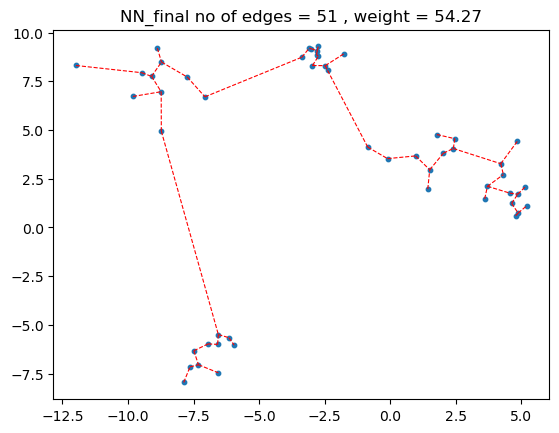

In [32]:
matplot(nn_final , "NN_final")

In [33]:
NN_clusters[0]

[0,
 {(-11.982021881543703, 8.309805920748971),
  (-9.808520080107835, 6.721414463197259),
  (-9.474040001156457, 7.93944383523473),
  (-9.101934022041025, 7.752058001312799),
  (-8.881319003567953, 9.20109530247551),
  (-8.733871274750205, 6.964714094939662),
  (-8.728214824793408, 4.938440217977632),
  (-8.721834697418362, 8.48589690413817),
  (-7.7398452153935215, 7.718024247090325),
  (-7.064854902946191, 6.7015986535703265)}]

In [34]:
NN_mst

{(-11.982021881543703,
  8.309805920748971): {(-9.474040001156457, 7.93944383523473)},
 (-9.808520080107835,
  6.721414463197259): {(-8.733871274750205, 6.964714094939662)},
 (-9.474040001156457,
  7.93944383523473): {(-9.101934022041025, 7.752058001312799)},
 (-9.101934022041025,
  7.752058001312799): {(-8.733871274750205, 6.964714094939662),
  (-8.721834697418362, 8.48589690413817)},
 (-8.881319003567953,
  9.20109530247551): {(-8.721834697418362, 8.48589690413817)},
 (-8.733871274750205, 6.964714094939662): set(),
 (-8.728214824793408,
  4.938440217977632): {(-8.733871274750205, 6.964714094939662)},
 (-8.721834697418362,
  8.48589690413817): {(-7.7398452153935215, 7.718024247090325)},
 (-7.875328667756696,
  -7.95669555494855): {(-7.634922962051645, -7.15840073154204)},
 (-7.7398452153935215,
  7.718024247090325): {(-7.064854902946191, 6.7015986535703265)},
 (-7.634922962051645,
  -7.15840073154204): {(-7.310884005212031, -7.047202672273382)},
 (-7.488856991426633,
  -6.329600933319